# Feature based approach


In [ ]:
#import libraries needed
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
# %matplotlib inline

### Data exploration

In [ ]:
#training data for feature based approach
raw = pd.read_csv("/kaggle/input/csm6420-a2/train_feat.csv")
data = raw.fillna(value=0)
print(f"Training Data: {data.info()}")
# print(data.head())

In [ ]:
X = data.iloc[:,2:]
y = data['Type']

In [ ]:
# different labels
diff_types = set(y)
print(diff_types)

In [ ]:
import random
for tpe in diff_types:
    plt.clf()
    for i in range(10):
        index = random.randint(1, 100)
        first_instance = data.loc[data.Type == tpe].iloc[index]
        feats = first_instance.drop(['Type', 'ID'])
        feats.plot()
    plt.xticks([])
    plt.xlabel("Features")
    plt.ylabel("Strength")
    plt.title(tpe)
    plt.show()

In [ ]:
variation =  data.groupby('Type').var()
plt.bar(variation.columns, variation.max())
variation.max().max()

# PreProcess data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6420, stratify = y)

In [ ]:
# x and y train data
from sklearn import preprocessing

#extract features and labels

#encode labels to 0, 1, 2, 3
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
print(np.unique(y_train_encoded))
print(label_encoder.inverse_transform(np.unique(y_train_encoded)))

# Encoded values:

- 0 = A
- 1 = N
- 2 = O
- 3 = ~

In [ ]:
#visualise distribution of class labels
data.Type.value_counts().plot(kind='bar')

## resample data to balance out the labels

In [ ]:
#resample data to balance labels
from sklearn.utils import resample
x_train['label'] = y_train_encoded
unbalanced = x_train

Ns = unbalanced[unbalanced.label == 1]
Os = unbalanced[unbalanced.label == 2]
As = unbalanced[unbalanced.label == 0]
noisy = unbalanced[unbalanced.label == 3]

print("N length: ", len(Ns))
print("O length: ", len(Os))
print("A length: ", len(As))
print("Noisy length: ", len(noisy))

avg = np.mean((len(Ns),len(Os) ,len(As)))

balanced_N = resample(Ns, n_samples = int(avg), replace=False)
balanced_O = resample(Os, n_samples = int(avg), replace=True)
balanced_A = resample(As, n_samples = int(avg), replace=True)
balanced_noise = resample(noisy, n_samples = int(avg), replace=True)
print("~~~~~~~~~~~~~~~~~~~~")
print("N balanced length: ", len(balanced_N))
print("O balanced length: ", len(balanced_O))
print("A balanced length: ", len(balanced_A))
print("Noisy length: ", len(noisy))

balanceddf = pd.concat([balanced_N, balanced_O,balanced_A, noisy])
print(balanceddf.label.value_counts())

balanceddf.label.value_counts().plot(kind='bar')

In [ ]:
print(balanceddf.head(1))

# Test and train data:

In [ ]:
x_train_balanced = balanceddf.drop(columns=['label'])
y_train_balanced = balanceddf.label
print(x_train_balanced.shape)
print(y_train_balanced.shape)
print(y_train_balanced.value_counts())

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(y_test.value_counts())

In [ ]:
print(x_train_balanced.columns)

# Normlise data with standard scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


x_train_normalised = pd.DataFrame(scaler.fit_transform(x_train_balanced), columns = x_train_balanced.columns)

x_test_normalised = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

# PCA dimenionality reduction

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components='mle')
pca.fit(x_train_normalised)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(var_cumsum, '+', linewidth=2)
plt.plot()
plt.ylabel('Cumulative PCA explained variance ratio')
plt.xlabel('Number of PCs')

plt.show()

In [ ]:
print(var_cumsum[[50, 100, 125, 140]])
print(f'PCs to exlpain 50% of variance: {np.where(var_cumsum>0.50)[0][0]}')
print(f'PCs to exlpain 90% of variance: {np.where(var_cumsum>0.90)[0][0]}')
print(f'PCs to exlpain 95% of variance: {np.where(var_cumsum>0.95)[0][0]}')
print(f'PCs to exlpain 99% of variance: {np.where(var_cumsum>0.99)[0][0]}')

# normalise data with minmax scaler

- fit pca the same as above

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()


x_train_normalised = pd.DataFrame(scaler.fit_transform(x_train_balanced), columns = x_train_balanced.columns)

x_test_normalised = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

pca = PCA(n_components='mle')
pca.fit(x_train_normalised)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(var_cumsum, '+', linewidth=2)
plt.plot()
plt.ylabel('Cumulative PCA explained variance ratio')
plt.xlabel('Number of PCs')

plt.show()
print(var_cumsum[[50, 100, 125, 140]])
print(f'PCs to exlpain 50% of variance: {np.where(var_cumsum>0.50)[0][0]}')
print(f'PCs to exlpain 90% of variance: {np.where(var_cumsum>0.90)[0][0]}')
print(f'PCs to exlpain 95% of variance: {np.where(var_cumsum>0.95)[0][0]}')
print(f'PCs to exlpain 99% of variance: {np.where(var_cumsum>0.99)[0][0]}')

# Modelling Experiments

fit un processed data to models

In [ ]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

random_seed = 6420
cross_val = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_seed)

hist = {}


In [ ]:
print(x_train.columns)
print(x_test.columns)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def report(clf):
    clf.fit(x_train_balanced, y_train_balanced)
    pred = clf.predict(x_test)
    out = label_encoder.inverse_transform(pred)
    report = classification_report(y_test, out, output_dict=True)
    f1 = report['weighted avg']['f1-score']
#     print('confusion matrix:\n',confusion_matrix(y_test, out))
#     print('\n\nclassification report:\n',report)
    print(f'=={clf}==\nweighted f1 score = {f1}')
    return f1

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

tree_params = {
    'n_estimators': [10, 100, 500, 1000],
    'max_depth': [1, 10, 25, 50, None],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
}

grid = GridSearchCV(RandomForestClassifier(),
                         tree_params, cv=cross_val, scoring='f1_weighted',
                         verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['random_forest'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")

# Naive Bayes
Use gaussian naive bayes as data is not binomial

In [ ]:
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes_grid = [{'var_smoothing': np.logspace(0,-9, 100)}]
grid = GridSearchCV(bayes,bayes_grid, cv=cross_val, scoring='f1_weighted',
                     verbose=0, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['Bayes'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

knn = KNeighborsClassifier()

knn_grid = {'n_neighbors': range(1, 50, 5),
           'weights': ['uniform', 'distance'],
           'algorithm': ['ball_tree', 'kd_tree', 'brute']
           }

grid = GridSearchCV(knn,knn_grid, cv=cross_val, scoring='f1_weighted',
                     verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['knn'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")

# Dimensionality Reduction and data scaling experiments

- Creating piplines for data standardising and dimensionality reduction

# Random forests 

In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipe = Pipeline(steps = [('scale', 'passthrough'),
                         ('reduce_dim', PCA()),
                         ('clf', RandomForestClassifier(random_state=6420))])

pipe_params = [
    {
        'scale': [StandardScaler()],
        'reduce_dim__n_components': ['mle', 63, 85, 125],
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [1, 10, 25, 50],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_features': ['sqrt', 'log2']
    },
    {
        'scale': [MinMaxScaler()],
        'reduce_dim__n_components': ['mle', 33, 53, 96],
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [1, 10, 25, 50],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_features': ['sqrt', 'log2']
    }
]

grid = GridSearchCV(pipe,pipe_params, cv=cross_val, scoring='f1_weighted', verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)

hist['Rf_PCA'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")

# Signal based end-to-end approach

## Data exploration

In [1]:
#import libraries needed
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
signal = pd.read_csv('/kaggle/input/csm6420-a2/train_signal.csv')
print(signal.head(1))

       ID Type     X0   X1     X2     X3     X4     X5     X6     X7  ...  \
0  B00000    N -0.107 -0.1 -0.086 -0.078 -0.071 -0.057 -0.049 -0.035  ...   

   X5990  X5991  X5992  X5993  X5994  X5995  X5996  X5997  X5998  X5999  
0 -1.108 -1.072 -1.028 -0.978 -0.912 -0.862 -0.804 -0.724  -0.63 -0.499  

[1 rows x 6002 columns]


In [3]:
print(signal.describe())

                 X0            X1            X2            X3            X4  \
count  13062.000000  13062.000000  13062.000000  13062.000000  13062.000000   
mean       0.002608      0.008771      0.015139      0.020327      0.024067   
std        1.444359      1.670797      1.907979      2.141337      2.329631   
min      -15.899000    -18.809000    -21.489000    -23.777000    -25.310000   
25%       -0.504750     -0.535000     -0.561750     -0.578000     -0.587000   
50%       -0.076500     -0.079000     -0.080000     -0.081000     -0.083000   
75%        0.466000      0.507000      0.543000      0.576000      0.606750   
max       16.082000     16.051000     17.947000     19.322000     19.578000   

                 X5            X6            X7            X8            X9  \
count  13062.000000  13062.000000  13062.000000  13062.000000  13062.000000   
mean       0.024725      0.023264      0.021561      0.019900      0.018962   
std        2.420211      2.424005      2.392944    

In [4]:
print(signal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13062 entries, 0 to 13061
Columns: 6002 entries, ID to X5999
dtypes: float64(6000), object(2)
memory usage: 598.1+ MB
None


In [33]:
y = signal['Type']
unique_types = set(y)

print(unique_types)

{'O', 'N', 'A', '~'}


In [34]:
# how unbalanced are the labels
print(signal.Type.value_counts())

N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

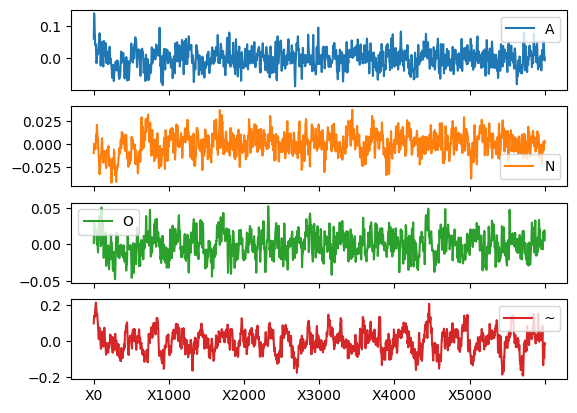

In [7]:
grouped = signal.groupby(['Type']).mean()
grouped.T.plot.line(subplots=True)

In [8]:
nans = signal.isna().sum().sum()
print(f'Total missing values: {nans}')

Total missing values: 815955


# Preprocess data

In [35]:
y = signal.Type

In [36]:
# replace missing values with 0 -> as if its just a 0 reading
no_missing = signal.fillna(0)

In [37]:
clean_X = no_missing.drop(['ID', 'Type'], axis=1)

In [38]:
def replace_outliers_with_nan(df, column, threshold=3):
    """Replace outliers in a dataframe column with NaNs."""
    mean = np.mean(df[column])
    std = np.std(df[column])
    cutoff = std * threshold
    lower, upper = mean - cutoff, mean + cutoff
    df[column] = np.where(np.logical_or(df[column] < lower, df[column] > upper), np.nan, df[column])
    return df

# Apply the function to each column in the dataframe containing ECG data
for col in clean_X:
    clean_X = replace_outliers_with_nan(clean_X, col)
    
clean_X = clean_X.fillna(0)

In [39]:
# scale data between -1 and 1 per each row
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(clean_X)

scaled_data=pd.DataFrame(scaler.fit_transform(clean_X),columns=clean_X.columns)
scaled_data['Type'] = y
print(scaled_data.columns)

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       ...
       'X5991', 'X5992', 'X5993', 'X5994', 'X5995', 'X5996', 'X5997', 'X5998',
       'X5999', 'Type'],
      dtype='object', length=6001)


## visualise some signals

In [2]:
from random import random
random_signal = scaled_data.iloc[random.random()]
random_signal.drop(['Type']).plot()
plt.gca().set_aspect(100)
plt.title(random_signal.Type)

NameError: name 'scaled_data' is not defined

In [41]:
print(scaled_data.Type)

0        N
1        N
2        N
3        ~
4        ~
        ..
13057    O
13058    O
13059    O
13060    N
13061    N
Name: Type, Length: 13062, dtype: object


X0   -0.2294
Name: 7, dtype: object


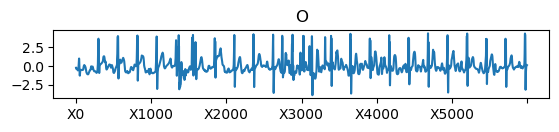

X0   -0.083687
Name: 0, dtype: object


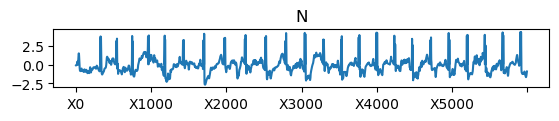

X0    0.91104
Name: 15, dtype: object


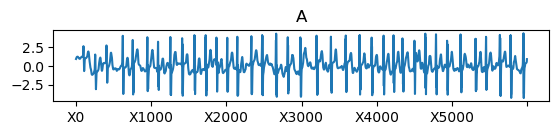

X0    0.443577
Name: 3, dtype: object


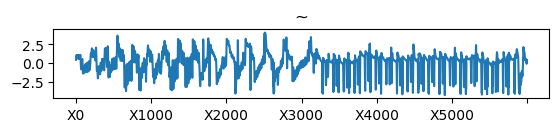

In [42]:
import random
for tpe in unique_types:
    plt.clf()
    for i in range(1):
        first_instance = scaled_data.loc[scaled_data.Type == tpe].iloc[0]
        print(first_instance.head(1))
        feats = first_instance.drop('Type')
        feats.plot() 
    plt.gca().set_aspect(100)
    plt.title(tpe)
    plt.show()

In [17]:
print(scaled_data.columns)

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       ...
       'X5991', 'X5992', 'X5993', 'X5994', 'X5995', 'X5996', 'X5997', 'X5998',
       'X5999', 'Type'],
      dtype='object', length=6001)


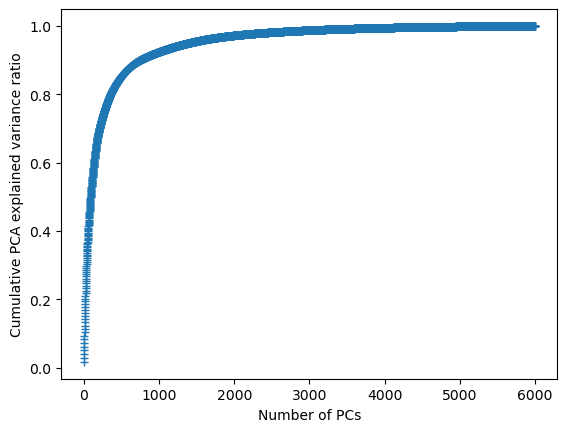

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_pca = scaled_data.drop('Type', axis=1)

pca = PCA()
pca.fit(X_pca)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(var_cumsum, '+', linewidth=2)
plt.plot()
plt.ylabel('Cumulative PCA explained variance ratio')
plt.xlabel('Number of PCs')

plt.show()

In [19]:
print(var_cumsum[[50, 100, 125, 140]])
print(f'PCs to exlpain 50% of variance: {np.where(var_cumsum>0.50)[0][0]}')
print(f'PCs to exlpain 90% of variance: {np.where(var_cumsum>0.90)[0][0]}')
print(f'PCs to exlpain 95% of variance: {np.where(var_cumsum>0.95)[0][0]}')
print(f'PCs to exlpain 99% of variance: {np.where(var_cumsum>0.99)[0][0]}')

[0.37632215 0.52760692 0.58136966 0.61034683]
PCs to exlpain 50% of variance: 89
PCs to exlpain 90% of variance: 747
PCs to exlpain 95% of variance: 1393
PCs to exlpain 99% of variance: 3265


In [43]:
pca = PCA(n_components=1393)
X = scaled_data.drop('Type', axis=1)
X = pca.fit_transform(X)

In [118]:
# split data into test and train data
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = scaled_data.drop('Type', axis=1)
y = scaled_data.Type
encoder = preprocessing.LabelEncoder()
encoded_y = encoder.fit_transform(y)
# y = tf.keras.utils.to_categorical(y-1, num_classes = 4)
print(np.unique(encoded_y))
print(encoder.inverse_transform(np.unique(encoded_y)))
x_train, x_test, y_train, y_test = train_test_split(X, encoded_y, test_size = 0.2, random_state = 6420, stratify=y)
print("Train shape: ", x_train.shape, y_train.shape)
print("Test shape: ", x_test.shape, y_test.shape)

[0 1 2 3]
['A' 'N' 'O' '~']
Train shape:  (10449, 6000) (10449,)
Test shape:  (2613, 6000) (2613,)


In [119]:
from imblearn.over_sampling import SMOTE

#resample training data using SMOTE

print(y_train.shape)

sm = SMOTE(random_state=6420, sampling_strategy='minority')
x_resamp, y_resamp = sm.fit_resample(x_train, y_train)
y_resamp=pd.Series(y_resamp)

(10449,)


In [120]:
print(y_resamp.value_counts())

1    6177
3    6177
2    3085
0     928
dtype: int64


# 1D CNN

In [121]:
# reshape data
X_resamp = np.array(x_resamp).reshape(x_resamp.shape[0], x_resamp.shape[1], 1)
X_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
print("X Train shape, resampled: ", X_resamp.shape)
print("y train shape, resampled: ", y_resamp.shape)
print("X Test shape: ", X_test.shape)
print("Y test shape: ", y_test.shape)

X Train shape, resampled:  (16367, 6000, 1)
y train shape, resampled:  (16367,)
X Test shape:  (2613, 6000, 1)
Y test shape:  (2613,)


In [122]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, MaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization

def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=25, activation='relu', input_shape=(X_test.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=128, kernel_size=15, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    return model

In [123]:
print(np.shape(y_resamp), np.shape(y_test))
print(np.shape(X_resamp), np.shape(X_test))

(16367,) (2613,)
(16367, 6000, 1) (2613, 6000, 1)


In [124]:
from tensorflow.keras.optimizers import SGD

cnn_model=create_cnn_model()
cnn_model.compile(optimizer=SGD(momentum=0.9), loss = 'sparse_categorical_crossentropy', metrics=['acc'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 5976, 128)         3328      
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 1195, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 1181, 128)         245888    
                                                                 
 dropout_12 (Dropout)        (None, 1181, 128)         0         
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 236, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_32 (Conv1D)          (None, 232, 128)        

In [1]:
cnn_model_history = cnn_model.fit(X_resamp, y_resamp, epochs=15, batch_size = 20, validation_split = 0.33, callbacks=early_stopping)

NameError: name 'cnn_model' is not defined

Text(0, 0.5, 'Accuracy')

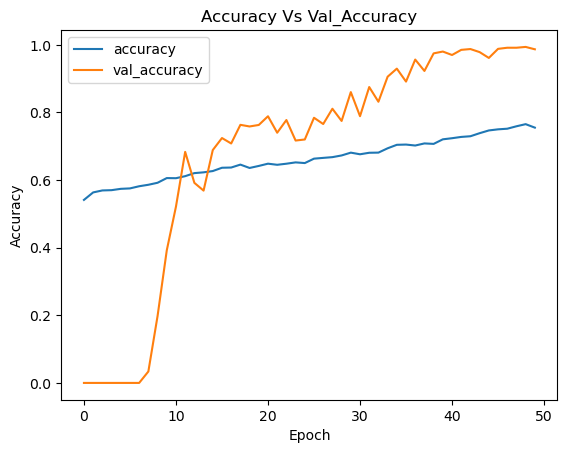

In [115]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

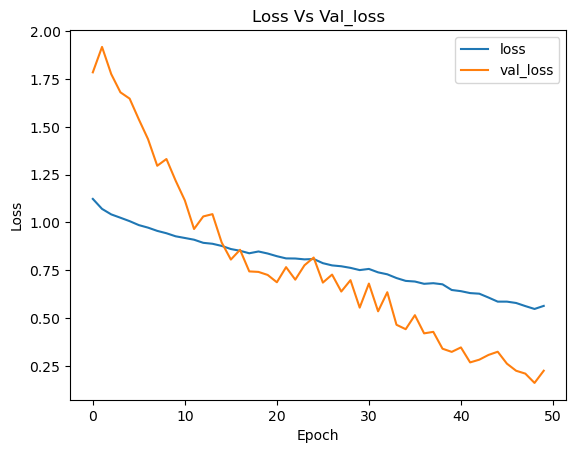

In [116]:
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.title('Loss Vs Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [117]:
from sklearn.metrics import classification_report
y_pred = cnn_model.predict(X_test)
true_pred = np.argmax(y_pred, axis=-1)

cr = classification_report(y_test, true_pred)
print(cr)

82/82 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.56      0.28      0.38       232
           1       0.68      0.92      0.78      1544
           2       0.59      0.30      0.40       772
           3       0.17      0.06      0.09        65

    accuracy                           0.66      2613
   macro avg       0.50      0.39      0.41      2613
weighted avg       0.63      0.66      0.62      2613



In [73]:
submission = pd.read_csv("/kaggle/input/csm6420-a2/test_signal.csv")
print(submission.head(1))
nan = submission.fillna(value=0)
ids = nan.ID
submission_data = nan.drop(columns='ID')
pca_data = pca.fit_transform(submission_data)
predictions = cnn_model.predict_generator(pca_data)
true_pred = np.argmax(predictionstions, axis=-1)
print(true_pred)
# out = encoder.inverse_transform(predictions)
# submission_dict = {"ID": ids, "Predicted": out}
# print(submission_dict)

       ID     X0     X1     X2     X3   X4    X5     X6     X7     X8  ...  \
0  C00000 -0.169 -0.174 -0.184 -0.189 -0.2 -0.21 -0.221 -0.226 -0.226  ...   

   X5990  X5991  X5992  X5993  X5994  X5995  X5996  X5997  X5998  X5999  
0  0.375  0.386  0.386   0.36  0.323  0.282   0.24  0.184  0.132   0.09  

[1 rows x 6001 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


[[7.7539887e-03 1.1188864e-03 9.7759295e-01 1.3534171e-02]
 [5.5009681e-01 6.0297318e-02 3.0978170e-01 7.9824202e-02]
 [9.9784374e-01 3.7560271e-04 1.2868123e-04 1.6518879e-03]
 ...
 [6.7094553e-01 5.8126184e-06 3.2056856e-01 8.4800702e-03]
 [9.9858522e-01 1.3643613e-03 3.2280016e-07 5.0157356e-05]
 [7.7886295e-01 4.7803719e-02 1.6615823e-01 7.1750162e-03]]


In [77]:
true_pred = np.argmax(predictions, axis=-1)


1    1424
2    1421
0     847
3     308
dtype: int64


# Submission

In [ ]:
def submit(clf):
    submission = pd.read_csv("/kaggle/input/csm6420-a2/test_feat.csv")
    print(submission.head(1))
    nan = submission.fillna(value=0)
    ids = nan.ID
    submission_data = nan.drop(columns='ID')
    predictions = clf.predict(submission_data)
    out = label_encoder.inverse_transform(predictions)
    submission_dict = {"ID": ids, "Predicted": out}
    final = pd.DataFrame.from_dict(submission_dict)
    final.to_csv(f"submission.csv", index=False)

In [ ]:
best_train_score = 0
best_test_score = 0
submission_clf = None
for clf in hist:
    test_f1 = report(hist[clf].best_estimator_)
    if test_f1 > best_test_score:
        best_test_score = test_f1
        submission_clf = hist[clf].best_estimator_
        best_train_score = hist[clf].best_score_

print(f"****\n\nBest Classifier = {submission_clf}\n\nTest Score = {best_test_score:.5f} \n\nTrain Score = {best_train_score:.5f}")
submit(submission_clf)